# Political Spectrum of Reddit Post Title
Muhammad Najmi Naufal

Reddit is very politically divided and can represent the political ideals and divisions in our society today!<br/><br/>
This notebook is an attempt to divide Reddit post titles by political spectrum using Natural Languange Processing model.<br/><br/>
The objective is to build a text classification deep learning model in TensorFlow framework. The model must predict whether each Reddit post lean to conservative or liberal side of political spectrum. Hopefully the model can also predict other texts from different sources.<br/><br/>
Dataset Source<br/>
https://www.kaggle.com/datasets/neelgajare/liberals-vs-conservatives-on-reddit-13000-posts

## Import Libraries

In [139]:
# general libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import tensorflow as tf
import re
import string
import nltk
import gensim
import warnings
import wordcloud
import pickle

In [140]:
# sklearn, tensorflow, and other modules
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from gensim.parsing.preprocessing import STOPWORDS
from tensorflow import keras
from keras.models import Model, Sequential
from keras.layers import TextVectorization, Dense, Input, Embedding, Dropout, GlobalAveragePooling1D, GlobalMaxPool1D, SimpleRNN, LSTM, GRU, Bidirectional
from keras.regularizers import l1, l2, L1L2
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.backend import clear_session

In [141]:
# download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# hide warnings 
warnings.filterwarnings('ignore')

# set random seed
random = 58
np.random.seed(random)
tf.random.set_seed(random)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Data Loading

In [142]:
# mount google drive to colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [143]:
# load dataset as pandas DataFrame
df = pd.read_csv('/content/drive/My Drive/hactiv8_ftds/p2_ml2/file_name.csv')

# dataset dimensions
df.shape

(12854, 9)

In [144]:
# split test data
data, data_test = train_test_split(df, test_size=0.1, random_state=random, stratify=df['Political Lean'])

# 5 first entries of data
data.head()

,Title,Political Lean,Score,Id,Subreddit,URL,Num of Comments,Text,Date Created
8831,Just because the Bible describes the Devil as ...,Conservative,185,t2wn34,conservatives,https://abcnews.go.com/Politics/sen-tom-cotton...,25,NaN,1.645993e+09
10317,The Catastrophe of Canada | Rex Murphy and Jor...,Conservative,0,sxam0b,Libertarian,https://youtube.com/watch?v=5efyUt5YDU0&featur...,5,NaN,1.645389e+09
11987,"""Socialists ignore the side of man that is the...",Conservative,122,r07tqs,Capitalism,https://www.reddit.com/r/Capitalism/comments/r...,213,NaN,1.637653e+09
730,Socialist Organizing: International Marxist Te...,Liberal,0,swt7wh,socialism,https://www.reddit.com/r/socialism/comments/sw...,3,I’m a member of the International Marxist Tend...,1.645333e+09
11330,DeSantis On Biden Flying Illegal Aliens Into F...,Conservative,3,sjmlwt,republicans,https://conservativebrief.com/desantis-4-59138/,1,NaN,1.643904e+09


In [145]:
# columns name, number of non-nulls, and data type 
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11568 entries, 8831 to 7818
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Title            11568 non-null  object 
 1   Political Lean   11568 non-null  object 
 2   Score            11568 non-null  int64  
 3   Id               11568 non-null  object 
 4   Subreddit        11568 non-null  object 
 5   URL              11568 non-null  object 
 6   Num of Comments  11568 non-null  int64  
 7   Text             2191 non-null   object 
 8   Date Created     11568 non-null  float64
dtypes: float64(1), int64(2), object(6)
memory usage: 903.8+ KB


This NLP model only need text and target columns. The 'Title' column can provide text data and the target column is 'Political Lean'.

In [146]:
# rename column
data.rename(columns={'Political Lean':'lean'}, inplace=True)

# lowercase columns
data.columns = data.columns.str.lower()

# select used columns
data = data[['title', 'lean']]

In [147]:
# check null values in columns
data.isnull().sum()

title    0
lean     0
dtype: int64

In [148]:
# number of unique values in columns
data.nunique()

title    11137
lean         2
dtype: int64

In [149]:
# liberal vs conservative posts
data.lean.value_counts()

Liberal         7487
Conservative    4081
Name: lean, dtype: int64

In [150]:
# most frequent posts
data.title.value_counts().head()

62 percent of voters say Putin wouldn't have invaded Ukraine if Trump were president: poll                                                                                                   5
Republicans maintain advantage in generic midterm ballot                                                                                                                                     4
Trump blasts Biden over Putin's invasion of Ukraine                                                                                                                                          4
The wonder of capitalism: A black entrepeneur who made it to the third richest person in Namibia despite the state enacting Apartheid                                                        3
Matt Gaetz's ex-girlfriend testifies to grand jury in sex trafficking probe; The development suggests the Department of Justice may be moving closer to indicting the Florida Republican.    3
Name: title, dtype: int64

From the information about the dataset above, all rows will be used.

## Exploratory Data Analysis (EDA)

It's quite tricky to visualize text data. WordCloud ordered the words count in a text data, then visualize the order by text size. A WordCloud image can fit a lot of words simultaneously, making it an effective way to visualize text data.

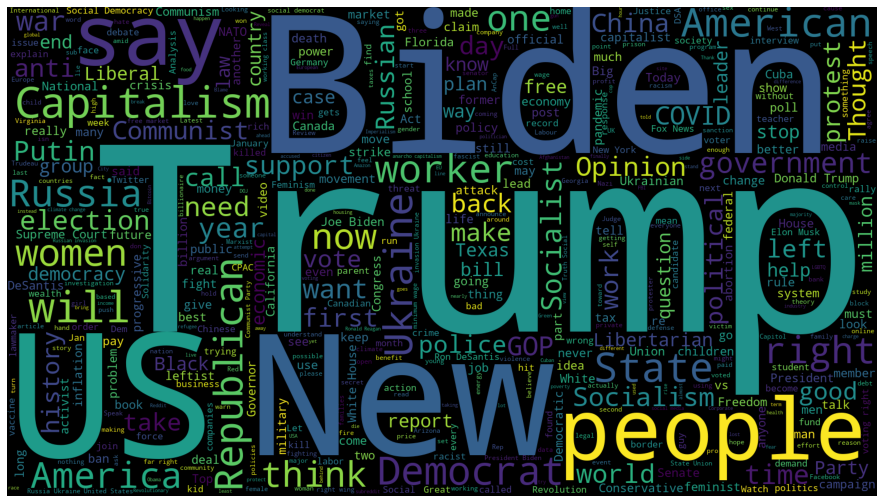

In [20]:
# most frequent words
cloud = wordcloud.WordCloud(max_words = 500, width = 1600,height = 900).generate(' '.join(data.title))

plt.figure(figsize=(16, 9))
plt.imshow(cloud)
plt.axis('off')
plt.show()

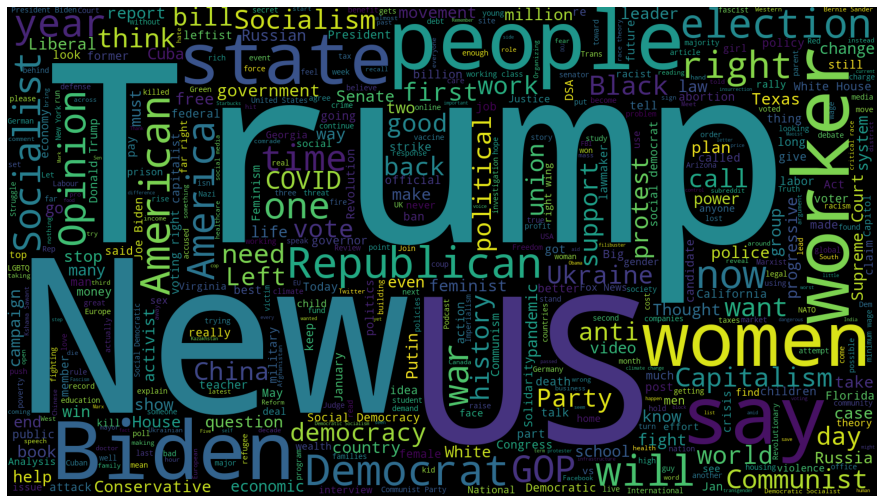

In [21]:
# most frequent words (liberal)
cloud = wordcloud.WordCloud(max_words = 500, width = 1600,height = 900).generate(' '.join( data[data.lean == 'Liberal'].title ))

plt.figure(figsize=(16, 9))
plt.imshow(cloud)
plt.axis('off')
plt.show()

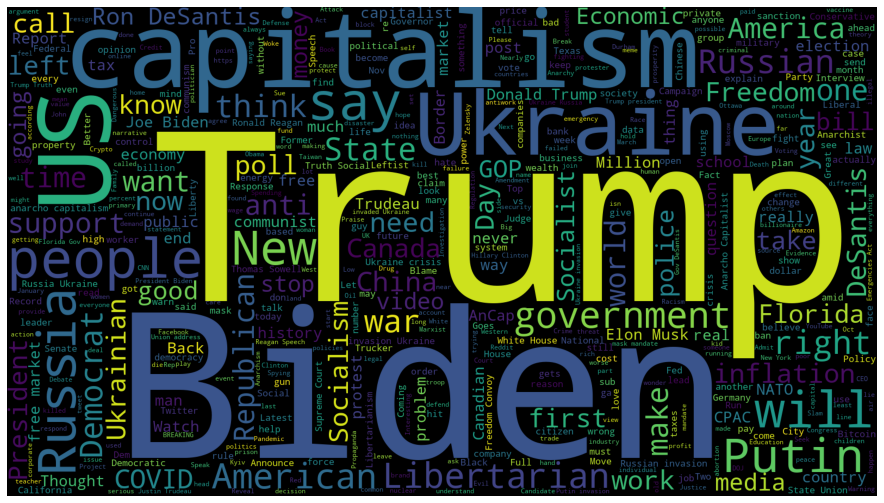

In [22]:
# most frequent words (liberal)
cloud = wordcloud.WordCloud(max_words = 500, width = 1600,height = 900).generate(' '.join( data[data.lean == 'Conservative'].title ))

plt.figure(figsize=(16, 9))
plt.imshow(cloud)
plt.axis('off')
plt.show()

Two reccuring names in the dataset are Trump and Biden. This frequent mention of the two most recent POTUS can be intepret as a corpus-specific stopwords, so their name can be removed from the datasets to see if it can improve the model.

## Data Preprocessing

Sequence of data preprocessing:
1. Dataset Splitting
2. Text Case Folding
3. Stop Words Removal
4. Stemming and Lemmatization
5. Train a Base Model
6. TensorFlow Pipeline

In [151]:
# binarize label column
data.lean = data.lean.map(dict(Conservative=0, Liberal=1))
data.lean.unique()

array([0, 1])

In [152]:
# split label column
y = data.pop('lean').to_frame()

# split train / validation data
X_train, X_val, y_train, y_val = train_test_split(data, y, test_size=0.2, random_state=random, stratify=y)

print('X_train shape :', X_train.shape)
print('X_val shape   :', X_val.shape)

X_train shape : (9254, 1)
X_val shape   : (2314, 1)


Let's take a sample from the train data for preprocessing methods testing.

In [153]:
# sample text
sample_text = X_train.loc[4117, 'title']

print(sample_text)

¡Viva La Socialismo! Leftist Gabriel Boric has Won the Chilean Election


This sample contains capital letters, and two punctuations (exclamation mark and interrobang).

In [154]:
# get non-string items
all_text = str()
for sentence in X_train.title.values:
    all_text += sentence
    
''.join(set(all_text))

'=…9L往éпiиzNQk￼ş]sй>\x99jóIàV😆🤮Ue️5💵O¶g·✅🥰🇵çBğ开ıYE🚒o•›ф😍🗡н🏿ëí🦀💀🎉ćK😅✖❓D¡ä😈■á$%♂H👇✊”m🏼S🚀🇸оа😋“f!"_❎🇦🎅câ£\u200b™–M`q#G继&\'7a来—⚡🇺💰🙏🤔;🔥⛓«ᵃ:\u200d👑-lF👍т🚛/ОX~P8ñ🌍😢ú😠р\x80»🤦🤡nе💻🇨🎩🤣л🌹?wbд😎h4öг🔪⚙6‘💪😂C🏽🔮\u2008🇷❤*Ч[p.с✝r)Z 🥴в✓м⋮,’Jy🤢3A\rdtʰvåu0@´\n2🐴\u200e😊1😭xW(🚰R🐐🤯|🥳T+💲'

There are non-string items (i.e. emojis) that should be removed from the text.

In [155]:
# remove emojis
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [156]:
# remove all non-printable symbols like "ड", "ட"
def remove_non_printable(text):
    text = text.encode("ascii", "ignore")
    return text.decode()

Case folding standardize word typing by lowecasing and removing unnecessary elements.

In [157]:
# case folding
sample_text = sample_text.lower() #lowercase
sample_text = re.sub(r'\d+', '', sample_text) #numbers
sample_text = re.sub(r'[¡]+\ *', ' ', sample_text) #interrobang
sample_text = sample_text.translate(str.maketrans('', '', string.punctuation)) #punctuations
sample_text = remove_emoji(sample_text) #emojis
sample_text = remove_non_printable(sample_text) #non-printable symbols
sample_text = sample_text.strip() #whitespaces

print(sample_text)

viva la socialismo leftist gabriel boric has won the chilean election


The sample is sucessfully case folded.

In [158]:
# word tokenization
word_token = word_tokenize(sample_text)

print('tokenized text :', word_token)
print('text length    :', len(word_token))

tokenized text : ['viva', 'la', 'socialismo', 'leftist', 'gabriel', 'boric', 'has', 'won', 'the', 'chilean', 'election']
text length    : 11


In [159]:
# nltk stopwords
stop = stopwords.words('english')

text_filtered = []

for w in word_token:
    if w not in stop:
        text_filtered.append(w)
        
print('filtered text :', text_filtered)
print('text length   :', len(text_filtered))

filtered text : ['viva', 'la', 'socialismo', 'leftist', 'gabriel', 'boric', 'chilean', 'election']
text length   : 8


In [160]:
# gensim stopwords
gensim_stop =STOPWORDS
extra_stop = gensim_stop.union(set(['trump', 'biden']))
text_reduced = [word for word in word_token if not word in extra_stop]

print('reduced text :', text_reduced)
print('text length   :', len(text_reduced))

reduced text : ['viva', 'la', 'socialismo', 'leftist', 'gabriel', 'boric', 'won', 'chilean', 'election']
text length   : 9


Stop words are any word in a stop list which are filtered out from the data.The stop list used in this notebook are from nltk and gensim. For the sample text, the word 'won' is in the gensim stop list but not in nltk's. We can also add corpus-spesific stopwords to gensim stop list.

In [161]:
# stemming
stem = PorterStemmer()

stemmed_words = []

for w in text_filtered:
    stemmed_words.append(stem.stem(w))

print('stemmed text :', stemmed_words)
print('text length  :', len(stemmed_words))

stemmed text : ['viva', 'la', 'socialismo', 'leftist', 'gabriel', 'boric', 'chilean', 'elect']
text length  : 8


In [162]:
# lemmatization
lem = WordNetLemmatizer()

lemmatized_words = []

for w in text_filtered:
    lemmatized_words.append(lem.lemmatize(w))
    
print('lemmatized text :', lemmatized_words)
print('text length     :', len(lemmatized_words))

lemmatized text : ['viva', 'la', 'socialismo', 'leftist', 'gabriel', 'boric', 'chilean', 'election']
text length     : 8


Stemming and lemmetization reduces words to its base form, for example election to elect.

In [163]:
# case folding function
def case_folding(df, col, corpus):  
  for i in df.index:
    doc = df.loc[i, col]
    doc = doc.lower() 
    doc = re.sub(r'\d+', '', doc) 
    doc = re.sub(r'[-\–\—\.\…\'\"\‘\’\“\”\¡]+\ *', ' ', doc) 
    doc = doc.translate(str.maketrans("", "", string.punctuation)) 
    doc = remove_emoji(doc) 
    doc = remove_non_printable(doc)
    doc = doc.strip() 
    corpus.append(doc)

In [164]:
# case folding train data
cf_text = []
case_folding(X_train, 'title', cf_text)
X_train_cf = pd.Series(cf_text, index=X_train.index)

# case folding val data
cf_text = []
case_folding(X_val, 'title', cf_text)
X_val_cf = pd.Series(cf_text, index=X_val.index)

# remove stopwords
X_train_stop = X_train_cf.apply(lambda x: ' '.join(x for x in x.split() if x not in stop))
X_val_stop = X_val_cf.apply(lambda x: ' '.join(x for x in x.split() if x not in stop))

print('before')
print(X_train.sample(5, random_state=random))
print('')
print('after')
print('')
print(X_train_stop.sample(5, random_state=random))

before
                                                   title
11471                                   Fucking disaster
10074  Mike Bloomberg: Democrats On Track For A ‘Wipe...
122                                   Patriot definition
9540   Putin knows that Biden is the modern Neville C...
2963              Growth and Anti-Growth - Miguel Amorós

after

11471                                   fucking disaster
10074    mike bloomberg democrats track wipeout november
122                                   patriot definition
9540        putin knows biden modern neville chamberlain
2963                     growth anti growth miguel amors
dtype: object


In [165]:
# check non-string items
all_text = str()
for sentence in X_train_stop.values:
    all_text += sentence
    
''.join(set(all_text))

'pirlz kmsjyfdntevcugbwqhoxa'

In [166]:
# stemming, lemmetizing function
def stem_lem(s, corpus):  
  for i in s.index:
    token = word_tokenize(s[i])
    token = [word for word in token if not word in extra_stop]
    doc = []
    for w in token:
      # sw = stem.stem(w) #  better result without
      lw = lem.lemmatize(w)
      doc.append(lw)
    corpus.append(doc)

In [167]:
# stemming, lemmetizing train data
sl_text = []
stem_lem(X_train_stop, sl_text)
X_train_sl = pd.Series(sl_text, index=X_train_stop.index).str.join(' ')

# stemming, lemmetizing val data
sl_text = []
stem_lem(X_val_stop, sl_text)
X_val_sl = pd.Series(sl_text, index=X_val_stop.index).str.join(' ')

print('before')
print(X_train_stop.sample(5, random_state=random))
print('')
print('after')
print(X_train_sl.sample(5, random_state=random))

before
11471                                   fucking disaster
10074    mike bloomberg democrats track wipeout november
122                                   patriot definition
9540        putin knows biden modern neville chamberlain
2963                     growth anti growth miguel amors
dtype: object

after
11471                                  fucking disaster
10074    mike bloomberg democrat track wipeout november
122                                  patriot definition
9540              putin know modern neville chamberlain
2963                     growth anti growth miguel amor
dtype: object


All preprocessing methods are applied to the datasets.

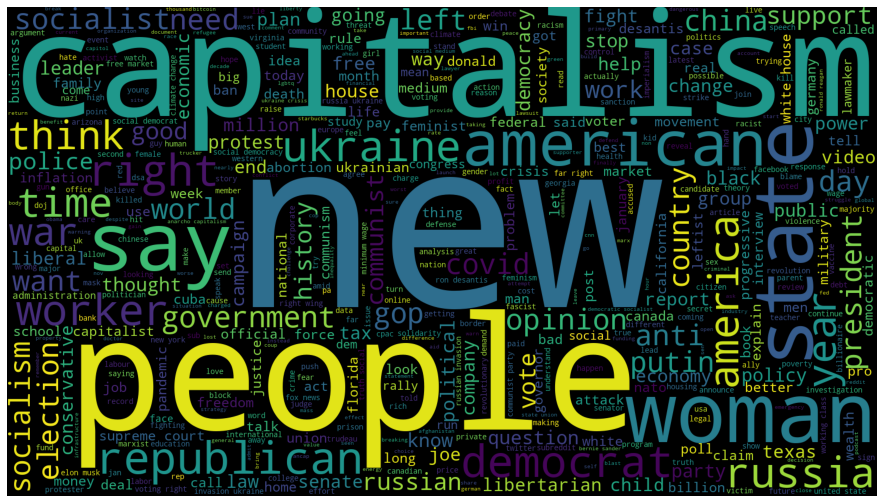

In [168]:
# most frequent words
cloud = wordcloud.WordCloud(max_words = 500, width = 1600,height = 900).generate(' '.join(X_train_sl))

plt.figure(figsize=(16, 9))
plt.imshow(cloud)
plt.axis('off')
plt.show()

This is the wordcloud of the cleaned data.

In [169]:
# count vectorizer
vec0 = CountVectorizer()
vec = CountVectorizer()

vec0.fit(X_train.title)
vec.fit(X_train_sl)

# vocabs count
print('original data     :', len(vec0.get_feature_names_out()))
print('preprocessed data :', len(vec.get_feature_names_out()))

original data     : 13754
preprocessed data : 11761


The data processing removed almost 2000 words from the train data vocab. This should make the modelling more efficent.

In [170]:
# vectorized datasets
X_train_vec0 = vec0.transform(X_train.title)
X_train_vec = vec.transform(X_train_sl)

X_val_vec0 = vec0.transform(X_val.title)
X_val_vec = vec.transform(X_val_sl)


# base model definition
nb = MultinomialNB()

The base model is a Bag-of-Words NLP model using Muiltinomial Naive Bayes Algorithm.

In [171]:
# predict original data
nb.fit(X_train_vec0, y_train)
y_pred = nb.predict(X_val_vec0)

# classification reportin
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.56      0.64       816
           1       0.79      0.89      0.84      1498

    accuracy                           0.77      2314
   macro avg       0.76      0.72      0.74      2314
weighted avg       0.77      0.77      0.77      2314



In [172]:
# predict preprocessed data
nb.fit(X_train_vec, y_train)
y_pred = nb.predict(X_val_vec)

# classification reportin
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.57      0.64       816
           1       0.79      0.89      0.84      1498

    accuracy                           0.78      2314
   macro avg       0.76      0.73      0.74      2314
weighted avg       0.77      0.78      0.77      2314



The base model metrics are slghtly improved by the preprocessing.

In [173]:
# perfect shuffling (dataset size + 1)
buffer_train = len(X_train_sl) + 1
buffer_val = len(X_val_sl) + 1

print('buffer size (train) :', buffer_train)
print('buffer size (val)   :', buffer_val)

buffer size (train) : 9255
buffer size (val)   : 2315


In [174]:
X_train_prep = X_train_sl.to_frame(name='title')
X_val_prep = X_val_sl.to_frame(name='title')

# tf pipeline
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_prep, y_train)).shuffle(buffer_size=buffer_train, seed=random).batch(64)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val_prep, y_val)).shuffle(buffer_size=buffer_val, seed=random, reshuffle_each_iteration=False).batch(64)

A TensorFlow piipeline is a set of methods in TF for creating a TF dataset. The methods used here are as follows:
1. from_tensor_slices: Creates a Dataset whose elements are slices of the given tensors. The given tensors are sliced along their first dimension, in this case DataFrame index.
2. shuffle: Randomly shuffles the elements of this dataset.
3. batch: Combines consecutive elements of this dataset into batches.

## Model Definition

The architecture for all models are based on functional API. These layers are used in all models:
1. input
2. text_vectorization: A preprocessing layer which maps text features to integer sequences.
3. embedding: Turns positive integers (indexes) into dense vectors of fixed size.
4. out: A single neuron dense layer.

### text vectorization

In [175]:
# text vectorization parameters
max_vocab_length = int(1 * len(vec.get_feature_names_out()) + 2)
max_length = int(2 * sum([len(i.split()) for i in X_train_prep.title]) / len(X_train_prep.title))

print('max vocab length :', max_vocab_length)
print('max length       :', max_length)

max vocab length : 11763
max length       : 14


In [176]:
# vectorization setup
text_vectorization = TextVectorization(max_tokens=max_vocab_length,
                                       standardize='lower_and_strip_punctuation',
                                       split='whitespace',
                                       ngrams=None,
                                       output_mode='int',
                                       output_sequence_length=max_length)

text_vectorization.adapt(X_train_prep)

In [177]:
# vectorization testing
print(sample_text)
print(text_vectorization([sample_text]))

viva la socialismo leftist gabriel boric has won the chilean election
tf.Tensor([[6353 1709 7057  176 1566 1446    1    1    1 2312   21    0    0    0]], shape=(1, 14), dtype=int64)


Text vectorization map the sample text to a 14-sequence tensor, where the number in each sequence represent a unique token index. The max index number equals max_tokens which is set to the vocab count of the train data. Since the number of tokens in the sample text is 11, there are 3 empty seqeunce represent by 0. Token value of 1 shows words outside of the vocab, in this case stop words.

### model 1

This model uses these layers:
- GlobalMaxPool1D: Downsamples the input representation by taking the maximum value over the time dimension.
- 4 neurons dense layer

In [178]:
# embedding setup
embedding = Embedding(input_dim=max_vocab_length,
                      output_dim=8,
                      embeddings_initializer='uniform',
                      input_length=max_length)

# build architecture
inputs = Input(shape=(1,), dtype='string')
x = text_vectorization(inputs)
x = embedding(x)
x = GlobalMaxPool1D()(x)
x = Dense(4, activation='relu')(x)
out = Dense(1, activation='sigmoid')(x)
model1 = Model(inputs, out)

# compile model
model1.compile(loss='binary_crossentropy',
               optimizer='adam',
               metrics=['accuracy'])

model1.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 14)               0         
 ectorization)                                                   
                                                                 
 embedding_6 (Embedding)     (None, 14, 8)             94104     
                                                                 
 global_max_pooling1d_2 (Glo  (None, 8)                0         
 balMaxPooling1D)                                                
                                                                 
 dense_9 (Dense)             (None, 4)                 36        
                                                                 
 dense_10 (Dense)            (None, 1)                 5   

### model 2

This model doubles embedding layer output dimension to 16, and add Dropout layers.

In [179]:
# embedding setup
embedding = Embedding(input_dim=max_vocab_length,
                      output_dim=16,
                      embeddings_initializer='uniform',
                      input_length=max_length)

# build architecture
inputs = Input(shape=(1,), dtype='string')
x = text_vectorization(inputs)
x = embedding(x)
x = Dropout(0.5, seed=random)(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.5, seed=random)(x)
x = Dense(4, activation='relu')(x) 
x = Dropout(0.5, seed=random)(x)
out = Dense(1, activation='sigmoid')(x)
model2 = Model(inputs, out)

# compile model
model2.compile(loss='binary_crossentropy',
               optimizer='adam',
               metrics=['accuracy'])

model2.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 14)               0         
 ectorization)                                                   
                                                                 
 embedding_7 (Embedding)     (None, 14, 16)            188208    
                                                                 
 dropout_13 (Dropout)        (None, 14, 16)            0         
                                                                 
 global_max_pooling1d_3 (Glo  (None, 16)               0         
 balMaxPooling1D)                                                
                                                                 
 dropout_14 (Dropout)        (None, 16)                0   

### model 3

This model replace the GlobalMaxPool1D layer with GlobalAveragePooling1D (Global average pooling operation for temporal data) and set the activation function of the first dense layer to 'softmax'.

In [180]:
# embedding setup
embedding = Embedding(input_dim=max_vocab_length,
                      output_dim=16,
                      embeddings_initializer='uniform',
                      input_length=max_length)

# build architecture
inputs = Input(shape=(1,), dtype='string')
x = text_vectorization(inputs)
x = embedding(x)
x = Dropout(0.5, seed=random)(x)
x = GlobalAveragePooling1D()(x)
x = Dropout(0.5, seed=random)(x)
x = Dense(4, activation='softmax')(x) 
x = Dropout(0.5, seed=random)(x)
out = Dense(1, activation='sigmoid')(x)
model3 = Model(inputs, out)

# compile model
model3.compile(loss='binary_crossentropy',
               optimizer='adam',
               metrics=['accuracy'])

model3.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 14)               0         
 ectorization)                                                   
                                                                 
 embedding_8 (Embedding)     (None, 14, 16)            188208    
                                                                 
 dropout_16 (Dropout)        (None, 14, 16)            0         
                                                                 
 global_average_pooling1d_1   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_17 (Dropout)        (None, 16)                0   

### model 4

This model replace the GlobalAveragePooling1D and the dense layer with two layers of SimpleRNN.



In [181]:
# embedding setup
embedding = Embedding(input_dim=max_vocab_length,
                      output_dim=16,
                      embeddings_initializer='uniform',
                      input_length=max_length)

# build architecture
inputs = Input(shape=(1,), dtype='string')
x = text_vectorization(inputs)
x = embedding(x)
x = Dropout(0.5, seed=random)(x)
x = SimpleRNN(4,return_sequences=True)(x)
x = Dropout(0.5, seed=random)(x)
x = SimpleRNN(4)(x)
x = Dropout(0.5, seed=random)(x)
out = Dense(1, activation='sigmoid')(x)
model4 = Model(inputs, out)

# compile model
model4.compile(loss='binary_crossentropy',
               optimizer='adam',
               metrics=['accuracy'])

model4.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 14)               0         
 ectorization)                                                   
                                                                 
 embedding_9 (Embedding)     (None, 14, 16)            188208    
                                                                 
 dropout_19 (Dropout)        (None, 14, 16)            0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 14, 4)             84        
                                                                 
 dropout_20 (Dropout)        (None, 14, 4)             0         
                                                           

### model 5

This model replace the SimpleRNN layers with a Biderectional LSTM layer. A biderectional layer consists of two RNNs (LSTMs or GRUs) that process the input sequence in one different direction to finally merge representations.


In [182]:
# embedding setup
embedding = Embedding(input_dim=max_vocab_length,
                      output_dim=16,
                      embeddings_initializer='uniform',
                      input_length=max_length)

# build architecture
inputs = Input(shape=(1,), dtype='string')
x = text_vectorization(inputs)
x = embedding(x)
x = Dropout(0.5, seed=random)(x)
x = Bidirectional(LSTM(4,dropout=0.5))(x)
x = Dropout(0.5, seed=random)(x)
out = Dense(1, activation='sigmoid')(x)
model5 = Model(inputs, out)

# compile model
model5.compile(loss='binary_crossentropy',
               optimizer='adam',
               metrics=['accuracy'])

model5.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 14)               0         
 ectorization)                                                   
                                                                 
 embedding_10 (Embedding)    (None, 14, 16)            188208    
                                                                 
 dropout_22 (Dropout)        (None, 14, 16)            0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 8)                672       
 nal)                                                            
                                                                 
 dropout_23 (Dropout)        (None, 8)                 0  

### model 6

This model replace the LSTM with GRU in the Biderectional layer.

In [183]:
# embedding setup
embedding = Embedding(input_dim=max_vocab_length,
                      output_dim=16,
                      embeddings_initializer='uniform',
                      input_length=max_length)

# build architecture
inputs = Input(shape=(1,), dtype='string')
x = text_vectorization(inputs)
x = embedding(x)
x = Dropout(0.5, seed=random)(x)
x = Bidirectional(GRU(4,dropout=0.5))(x)
x = Dropout(0.5, seed=random)(x)
out = Dense(1, activation='sigmoid')(x)
model6 = Model(inputs, out)

# compile model
model6.compile(loss='binary_crossentropy',
               optimizer='adam',
               metrics=['accuracy'])

model6.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 14)               0         
 ectorization)                                                   
                                                                 
 embedding_11 (Embedding)    (None, 14, 16)            188208    
                                                                 
 dropout_24 (Dropout)        (None, 14, 16)            0         
                                                                 
 bidirectional_3 (Bidirectio  (None, 8)                528       
 nal)                                                            
                                                                 
 dropout_25 (Dropout)        (None, 8)                 0  

## Model Training

### model 1

In [184]:
# callback setup
my_callbacks = [EarlyStopping(patience=2),
                ModelCheckpoint(filepath='model1.tf', 
                                save_best_only=True)]

# train model
history1 = model1.fit(train_dataset, 
                      epochs=100,
                      callbacks=my_callbacks,
                      validation_data=val_dataset)                

Epoch 1/100
145/145 [==============================] - 3s 14ms/step - loss: 0.6857 - accuracy: 0.5848 - val_loss: 0.6672 - val_accuracy: 0.6487
Epoch 2/100
145/145 [==============================] - 2s 10ms/step - loss: 0.6360 - accuracy: 0.6753 - val_loss: 0.6095 - val_accuracy: 0.7014
Epoch 3/100
145/145 [==============================] - 1s 10ms/step - loss: 0.5521 - accuracy: 0.7427 - val_loss: 0.5496 - val_accuracy: 0.7398
Epoch 4/100
145/145 [==============================] - 2s 13ms/step - loss: 0.4569 - accuracy: 0.8051 - val_loss: 0.5199 - val_accuracy: 0.7615
Epoch 5/100
145/145 [==============================] - 1s 10ms/step - loss: 0.3733 - accuracy: 0.8552 - val_loss: 0.5126 - val_accuracy: 0.7571
Epoch 6/100
145/145 [==============================] - 0s 3ms/step - loss: 0.3044 - accuracy: 0.8944 - val_loss: 0.5196 - val_accuracy: 0.7541
Epoch 7/100
145/145 [==============================] - 0s 3ms/step - loss: 0.2509 - accuracy: 0.9156 - val_loss: 0.5378 - val_accuracy: 0

### model 2

In [185]:
# callback setup
my_callbacks = [EarlyStopping(patience=2),
                ModelCheckpoint(filepath='model2.tf', 
                                save_best_only=True)]

# train model
history2 = model2.fit(train_dataset, 
                      epochs=100,
                      callbacks=my_callbacks,
                      validation_data=val_dataset)        

Epoch 1/100
145/145 [==============================] - 3s 14ms/step - loss: 0.6721 - accuracy: 0.6395 - val_loss: 0.6597 - val_accuracy: 0.6474
Epoch 2/100
145/145 [==============================] - 2s 13ms/step - loss: 0.6527 - accuracy: 0.6471 - val_loss: 0.6455 - val_accuracy: 0.6474
Epoch 3/100
145/145 [==============================] - 2s 14ms/step - loss: 0.6401 - accuracy: 0.6472 - val_loss: 0.6350 - val_accuracy: 0.6474
Epoch 4/100
145/145 [==============================] - 2s 14ms/step - loss: 0.6291 - accuracy: 0.6478 - val_loss: 0.6241 - val_accuracy: 0.6474
Epoch 5/100
145/145 [==============================] - 2s 13ms/step - loss: 0.6205 - accuracy: 0.6527 - val_loss: 0.6150 - val_accuracy: 0.6474
Epoch 6/100
145/145 [==============================] - 2s 13ms/step - loss: 0.6052 - accuracy: 0.6657 - val_loss: 0.5979 - val_accuracy: 0.6573
Epoch 7/100
145/145 [==============================] - 2s 16ms/step - loss: 0.5923 - accuracy: 0.6760 - val_loss: 0.5849 - val_accuracy:

### model 3

In [186]:
# callback setup
my_callbacks = [EarlyStopping(patience=2),
                ModelCheckpoint(filepath='model3.tf', 
                                save_best_only=True)]

# train model
history3 = model3.fit(train_dataset, 
                      epochs=100,
                      callbacks=my_callbacks,
                      validation_data=val_dataset)        

Epoch 1/100
145/145 [==============================] - 3s 14ms/step - loss: 0.6940 - accuracy: 0.5237 - val_loss: 0.6648 - val_accuracy: 0.6474
Epoch 2/100
145/145 [==============================] - 2s 17ms/step - loss: 0.6630 - accuracy: 0.6164 - val_loss: 0.6517 - val_accuracy: 0.6474
Epoch 3/100
145/145 [==============================] - 2s 13ms/step - loss: 0.6562 - accuracy: 0.6417 - val_loss: 0.6478 - val_accuracy: 0.6474
Epoch 4/100
145/145 [==============================] - 2s 13ms/step - loss: 0.6527 - accuracy: 0.6460 - val_loss: 0.6449 - val_accuracy: 0.6474
Epoch 5/100
145/145 [==============================] - 2s 13ms/step - loss: 0.6495 - accuracy: 0.6502 - val_loss: 0.6409 - val_accuracy: 0.6474
Epoch 6/100
145/145 [==============================] - 2s 14ms/step - loss: 0.6403 - accuracy: 0.6565 - val_loss: 0.6338 - val_accuracy: 0.6474
Epoch 7/100
145/145 [==============================] - 2s 14ms/step - loss: 0.6304 - accuracy: 0.6648 - val_loss: 0.6234 - val_accuracy:

### model 4

In [187]:
# callback setup
my_callbacks = [EarlyStopping(patience=2),
                ModelCheckpoint(filepath='model4.tf', 
                                save_best_only=True)]

# train model
history4 = model4.fit(train_dataset, 
                      epochs=100,
                      callbacks=my_callbacks,
                      validation_data=val_dataset)        

Epoch 1/100
145/145 [==============================] - 7s 38ms/step - loss: 0.6869 - accuracy: 0.5994 - val_loss: 0.6400 - val_accuracy: 0.6474
Epoch 2/100
145/145 [==============================] - 5s 34ms/step - loss: 0.6415 - accuracy: 0.6572 - val_loss: 0.5691 - val_accuracy: 0.7178
Epoch 3/100
145/145 [==============================] - 5s 33ms/step - loss: 0.5548 - accuracy: 0.7381 - val_loss: 0.5476 - val_accuracy: 0.7290
Epoch 4/100
145/145 [==============================] - 1s 10ms/step - loss: 0.4846 - accuracy: 0.7941 - val_loss: 0.5559 - val_accuracy: 0.7161
Epoch 5/100
145/145 [==============================] - 1s 9ms/step - loss: 0.4221 - accuracy: 0.8346 - val_loss: 0.5579 - val_accuracy: 0.7282


### model 5

In [188]:
# callback setup
my_callbacks = [EarlyStopping(patience=2),
                ModelCheckpoint(filepath='model5.tf', 
                                save_best_only=True)]

# train model
history5 = model5.fit(train_dataset, 
                      epochs=100,
                      callbacks=my_callbacks,
                      validation_data=val_dataset)        

Epoch 1/100
145/145 [==============================] - ETA: 0s - loss: 0.6647 - accuracy: 0.6390

INFO:tensorflow:Assets written to: model5.tf/assets


INFO:tensorflow:Assets written to: model5.tf/assets


145/145 [==============================] - 28s 157ms/step - loss: 0.6647 - accuracy: 0.6390 - val_loss: 0.6462 - val_accuracy: 0.6474
Epoch 2/100
145/145 [==============================] - ETA: 0s - loss: 0.6350 - accuracy: 0.6488

INFO:tensorflow:Assets written to: model5.tf/assets


INFO:tensorflow:Assets written to: model5.tf/assets


145/145 [==============================] - 17s 115ms/step - loss: 0.6350 - accuracy: 0.6488 - val_loss: 0.6100 - val_accuracy: 0.6474
Epoch 3/100
142/145 [============================>.] - ETA: 0s - loss: 0.5738 - accuracy: 0.6948

INFO:tensorflow:Assets written to: model5.tf/assets


INFO:tensorflow:Assets written to: model5.tf/assets


145/145 [==============================] - 15s 106ms/step - loss: 0.5738 - accuracy: 0.6948 - val_loss: 0.5424 - val_accuracy: 0.7347
Epoch 4/100
145/145 [==============================] - ETA: 0s - loss: 0.4777 - accuracy: 0.7891

INFO:tensorflow:Assets written to: model5.tf/assets


INFO:tensorflow:Assets written to: model5.tf/assets


145/145 [==============================] - 17s 114ms/step - loss: 0.4777 - accuracy: 0.7891 - val_loss: 0.5100 - val_accuracy: 0.7580
Epoch 5/100
145/145 [==============================] - 2s 12ms/step - loss: 0.4134 - accuracy: 0.8295 - val_loss: 0.5151 - val_accuracy: 0.7554
Epoch 6/100
145/145 [==============================] - 2s 12ms/step - loss: 0.3642 - accuracy: 0.8523 - val_loss: 0.5513 - val_accuracy: 0.7623


### model 6

In [189]:
# callback setup
my_callbacks = [EarlyStopping(patience=2),
                ModelCheckpoint(filepath='model6.tf', 
                                save_best_only=True)]

# train model
history6 = model6.fit(train_dataset, 
                      epochs=100,
                      callbacks=my_callbacks,
                      validation_data=val_dataset)      

Epoch 1/100
143/145 [============================>.] - ETA: 0s - loss: 0.6585 - accuracy: 0.6443

INFO:tensorflow:Assets written to: model6.tf/assets


INFO:tensorflow:Assets written to: model6.tf/assets


145/145 [==============================] - 20s 100ms/step - loss: 0.6587 - accuracy: 0.6440 - val_loss: 0.6451 - val_accuracy: 0.6474
Epoch 2/100
144/145 [============================>.] - ETA: 0s - loss: 0.6395 - accuracy: 0.6485

INFO:tensorflow:Assets written to: model6.tf/assets


INFO:tensorflow:Assets written to: model6.tf/assets


145/145 [==============================] - 14s 100ms/step - loss: 0.6392 - accuracy: 0.6489 - val_loss: 0.6227 - val_accuracy: 0.6478
Epoch 3/100
144/145 [============================>.] - ETA: 0s - loss: 0.5768 - accuracy: 0.6940

INFO:tensorflow:Assets written to: model6.tf/assets


INFO:tensorflow:Assets written to: model6.tf/assets


145/145 [==============================] - 15s 101ms/step - loss: 0.5768 - accuracy: 0.6943 - val_loss: 0.5424 - val_accuracy: 0.7511
Epoch 4/100
143/145 [============================>.] - ETA: 0s - loss: 0.5005 - accuracy: 0.7721

INFO:tensorflow:Assets written to: model6.tf/assets


INFO:tensorflow:Assets written to: model6.tf/assets


145/145 [==============================] - 15s 102ms/step - loss: 0.5003 - accuracy: 0.7718 - val_loss: 0.5251 - val_accuracy: 0.7442
Epoch 5/100
142/145 [============================>.] - ETA: 0s - loss: 0.4581 - accuracy: 0.7965

INFO:tensorflow:Assets written to: model6.tf/assets


INFO:tensorflow:Assets written to: model6.tf/assets


145/145 [==============================] - 15s 102ms/step - loss: 0.4564 - accuracy: 0.7974 - val_loss: 0.5124 - val_accuracy: 0.7545
Epoch 6/100
145/145 [==============================] - 2s 13ms/step - loss: 0.4224 - accuracy: 0.8214 - val_loss: 0.5134 - val_accuracy: 0.7584
Epoch 7/100
145/145 [==============================] - 2s 14ms/step - loss: 0.3895 - accuracy: 0.8370 - val_loss: 0.5160 - val_accuracy: 0.7615


### train data evaluation

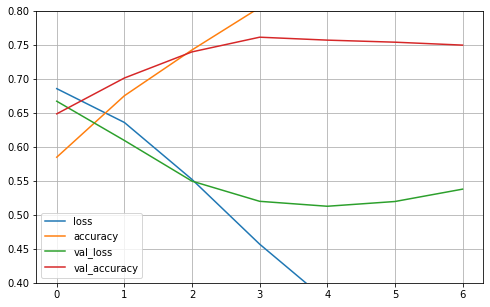

In [190]:
# model1 metrics history
metrics1 = pd.DataFrame(history1.history)
metrics1.plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.4, 0.8)
plt.show()

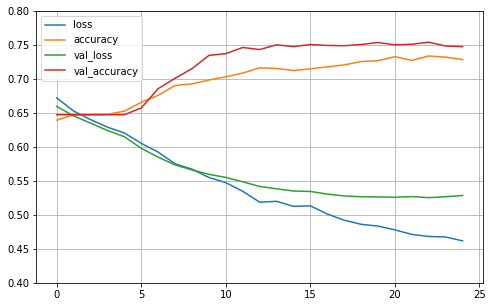

In [191]:
# model2 metrics history
metrics2 = pd.DataFrame(history2.history)
metrics2.plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.4, 0.8)
plt.show()

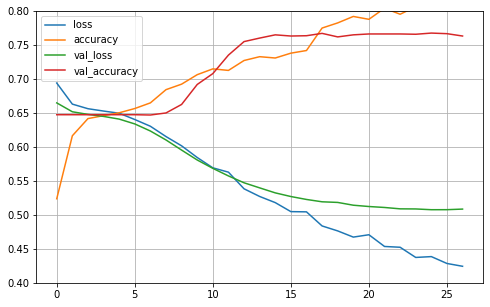

In [192]:
# model3 metrics history
metrics3 = pd.DataFrame(history3.history)
metrics3.plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.4, 0.8)
plt.show()

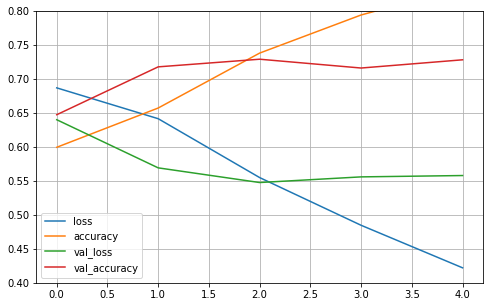

In [193]:
# model4 metrics history
metrics4 = pd.DataFrame(history4.history)
metrics4.plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.4, 0.8)
plt.show()

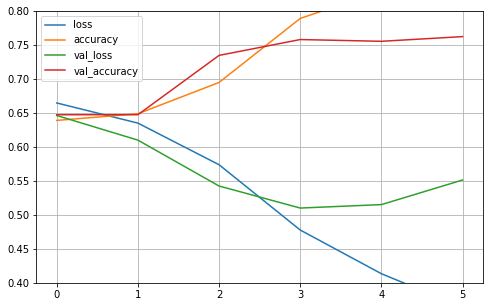

In [194]:
# model5 metrics history
metrics5 = pd.DataFrame(history5.history)
metrics5.plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.4, 0.8)
plt.show()

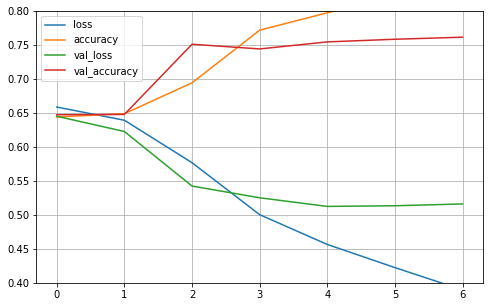

In [195]:
# model6 metrics history
metrics6 = pd.DataFrame(history6.history)
metrics6.plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.4, 0.8)
plt.show()

Overfitting happens in all of the models. From the metrics history, model 2 and 3 overfit the least. Adding Dropout layers indeed surpress the overfitting.

In [196]:
# predict validation data
y_pred1 = model1.predict(X_val_prep)
y_pred1 = np.where(y_pred1 >= 0.5, 1, 0).squeeze()

# model1 classification report
print(classification_report(y_val, y_pred1))

              precision    recall  f1-score   support

           0       0.67      0.57      0.62       816
           1       0.78      0.85      0.81      1498

    accuracy                           0.75      2314
   macro avg       0.73      0.71      0.72      2314
weighted avg       0.74      0.75      0.74      2314



In [197]:
# predict validation data
y_pred2 = model2.predict(X_val_prep)
y_pred2 = np.where(y_pred2 >= 0.5, 1, 0).squeeze()

# model2 classification report
print(classification_report(y_val, y_pred2))

              precision    recall  f1-score   support

           0       0.70      0.50      0.58       816
           1       0.77      0.88      0.82      1498

    accuracy                           0.75      2314
   macro avg       0.73      0.69      0.70      2314
weighted avg       0.74      0.75      0.74      2314



In [198]:
# predict validation data
y_pred3 = model3.predict(X_val_prep)
y_pred3 = np.where(y_pred3 >= 0.5, 1, 0).squeeze()

# model3 classification report
print(classification_report(y_val, y_pred3))

              precision    recall  f1-score   support

           0       0.70      0.58      0.64       816
           1       0.79      0.86      0.82      1498

    accuracy                           0.76      2314
   macro avg       0.74      0.72      0.73      2314
weighted avg       0.76      0.76      0.76      2314



In [199]:
# predict validation data
y_pred4 = model4.predict(X_val_prep)
y_pred4 = np.where(y_pred4 >= 0.5, 1, 0).squeeze()

# model4 classification report
print(classification_report(y_val, y_pred4))

              precision    recall  f1-score   support

           0       0.62      0.60      0.61       816
           1       0.79      0.80      0.79      1498

    accuracy                           0.73      2314
   macro avg       0.70      0.70      0.70      2314
weighted avg       0.73      0.73      0.73      2314



In [200]:
# predict validation data
y_pred5 = model5.predict(X_val_prep)
y_pred5 = np.where(y_pred5 >= 0.5, 1, 0).squeeze()

# model5 classification report
print(classification_report(y_val, y_pred5))

              precision    recall  f1-score   support

           0       0.70      0.57      0.63       816
           1       0.79      0.87      0.83      1498

    accuracy                           0.76      2314
   macro avg       0.74      0.72      0.73      2314
weighted avg       0.76      0.76      0.76      2314



In [201]:
# predict validation data
y_pred6 = model6.predict(X_val_prep)
y_pred6 = np.where(y_pred6 >= 0.5, 1, 0).squeeze()

# model6 classification report
print(classification_report(y_val, y_pred6))

              precision    recall  f1-score   support

           0       0.73      0.51      0.60       816
           1       0.77      0.90      0.83      1498

    accuracy                           0.76      2314
   macro avg       0.75      0.71      0.72      2314
weighted avg       0.76      0.76      0.75      2314



The accuracy of the models range from 0.73-0.77. Between the non-rnn models (1,2,3), model 3 has the best metrics, while between the rnn-based models (4,5,6), model 5 and 6 yields better results. 

In [202]:
print('val_loss')
print('model1 :', metrics1['val_loss'].min())
print('model2 :', metrics2['val_loss'].min())
print('model3 :', metrics3['val_loss'].min())
print('model4 :', metrics4['val_loss'].min())
print('model5 :', metrics5['val_loss'].min())
print('model6 :', metrics6['val_loss'].min())

val_loss
model1 : 0.5126488208770752
model2 : 0.5253182649612427
model3 : 0.5075634717941284
model4 : 0.5475637912750244
model5 : 0.5100052356719971
model6 : 0.5124289393424988


Model 3 is considered as the best model because it fits better, has the smallest val_loss, and the highest accuracy. 

## Model Evaluation

Let's try to predict the test data using model 3.

In [203]:
# rename column
data_test.rename(columns={'Political Lean':'lean'}, inplace=True)

# lowercase columns
data_test.columns = data_test.columns.str.lower()

# select used columns
data_test = data_test[['title', 'lean']]

# binarize label column
data_test.lean = data_test.lean.map(dict(Conservative=0, Liberal=1))

# split label column
y_test = data_test.pop('lean').to_frame()

In [204]:
# case folding test data
cf_text = []
case_folding(data_test, 'title', cf_text)
X_test_cf = pd.Series(cf_text, index=data_test.index)

# remove stopwords
X_test_stop = X_test_cf.apply(lambda x: ' '.join(x for x in x.split() if x not in stop))

# stemming, lemmetizing train data
sl_text = []
stem_lem(X_test_stop, sl_text)
X_test_sl = pd.Series(sl_text, index=X_test_stop.index).str.join(' ')

X_test_prep = X_test_sl.to_frame(name='title')

In [205]:
# predict validation data
y_pred = model3.predict(X_test_prep)
y_pred = np.where(y_pred >= 0.5, 1, 0).squeeze()

# model1 classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.61      0.64       454
           1       0.80      0.84      0.82       832

    accuracy                           0.76      1286
   macro avg       0.74      0.73      0.73      1286
weighted avg       0.76      0.76      0.76      1286



There difference between val and test metrics are insignifcant.

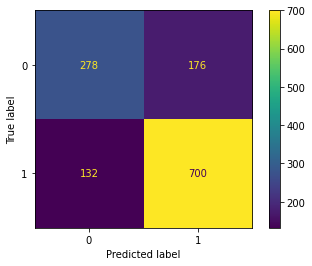

In [206]:
# confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred);

In [207]:
# test vs predict comparison
pred_df = pd.DataFrame(y_pred, columns=['pred'], index=y_test.index)
test_df = pd.concat([y_test, pred_df], axis=1)
test_df.replace({0: 'Conservative', 1: 'Liberal'}, inplace=True)
test_df.sample(10, random_state=random)

,lean,pred
10381,Conservative,Conservative
5444,Liberal,Liberal
1745,Liberal,Liberal
1636,Liberal,Conservative
5711,Liberal,Conservative
4944,Liberal,Conservative
10533,Conservative,Liberal
5644,Liberal,Liberal
12750,Conservative,Liberal
10664,Conservative,Liberal


From 10 samples, there ratio between liberal and conservative is 6:4. The model only predict 4 samples correctly, which is caused by randomness of the sampling.

## Model Inference

The Game of Thrones TV series script is used for inference data. from this data we can observe the behaviour of the model when predicting non-US political themed text. 

In [208]:
# load dataset as pandas DataFrame
inf = pd.read_csv('/content/drive/My Drive/hactiv8_ftds/p2_ml2/Game_of_Thrones_Script.csv')

# 5 first entries of data
inf.head()

,Release Date,Season,Episode,Episode Title,Name,Sentence
0,2011-04-17,Season 1,Episode 1,Winter is Coming,waymar royce,What do you expect? They're savages. One lot s...
1,2011-04-17,Season 1,Episode 1,Winter is Coming,will,I've never seen wildlings do a thing like this...
2,2011-04-17,Season 1,Episode 1,Winter is Coming,waymar royce,How close did you get?
3,2011-04-17,Season 1,Episode 1,Winter is Coming,will,Close as any man would.
4,2011-04-17,Season 1,Episode 1,Winter is Coming,gared,We should head back to the wall.


In [209]:
# characters with most sentences
inf.Name.value_counts().head(7)

tyrion lannister      1760
jon snow              1133
daenerys targaryen    1048
cersei lannister      1005
jaime lannister        945
sansa stark            784
arya stark             783
Name: Name, dtype: int64

In [210]:
text_arya = inf[inf.Name == 'arya stark'].Sentence.to_frame()

### arya stark

In [211]:
# case folding 
cf_text = []
case_folding(text_arya, 'Sentence', cf_text)
arya_cf = pd.Series(cf_text, index=text_arya.index)

# remove stopwords
arya_stop = arya_cf.apply(lambda x: ' '.join(x for x in x.split() if x not in stop))

# stemming, lemmetizing 
sl_text = []
stem_lem(arya_stop, sl_text)
arya_sl = pd.Series(sl_text, index=arya_stop.index).str.join(' ')

arya_prep = arya_sl.to_frame(name='Sentence')

In [212]:
# predict data
arya_lean = model3.predict(arya_prep)
arya_lean = np.where(arya_lean >= 0.5, 1, 0).squeeze()

In [219]:
arya = pd.DataFrame(arya_lean, columns=['lean'], index=arya_prep.index)
arya_df = pd.concat([text_arya, arya], axis=1)
arya_df.lean.value_counts()

1    601
0    182
Name: lean, dtype: int64

In [225]:
arya_df[arya_df.lean == 1].sample(10, random_state=random)

,Sentence,lean
10546,The first man.,1
11649,Father!,1
4880,The one who tortures everyone.,1
3808,Who asked questions?,1
7709,Shh.,1
8992,There's someone out there.,1
540,Stop it!,1
7724,"No, who do you fight for?",1
3814,Who's your mom?,1
21115,steps forward and throws her arms around BRAN....,1


In [226]:
arya_df[arya_df.lean == 0].sample(10, random_state=random)

,Sentence,lean
12449,Meryn Trant. That's why Ser Meryn-,0
22653,First I robbed you.,0
10540,Sorry.,0
8614,You just said you were serving Lord Beric.,0
16984,"No! No! No, you don't die! Don't die!",0
23049,Guess I've changed.,0
21100,They say you killed Joffrey. Did you?,0
6292,"He didn't say. He just said, ""Walk through the...",0
5407,"I'll fetch more wood for the fire, my lord.",0
10548,Valar morghulis.,0


The inference dataset seems random.

## Conclusion

The best model for predicting US political spectrum has a 78% accuracy. This model is not a neural network based model. The neural network models can be improve by using bigger data for train. The dataset used here seems too small to properly modeled by NN models, indicate by the constant overfitting of the models. The model can't be used for predicting non-US political text, since the inference data most likely predict by random.